Epoch 1/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 6.2001, Val Loss: 5.4007, Train Acc: 0.1513, Val Acc: 0.0000


Epoch 2/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 5.4804, Val Loss: 5.0127, Train Acc: 0.1876, Val Acc: 0.0000


Epoch 3/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 5.1422, Val Loss: 4.8279, Train Acc: 0.2070, Val Acc: 0.0000


Epoch 4/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 4.9303, Val Loss: 4.7383, Train Acc: 0.2202, Val Acc: 0.0000


Epoch 5/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 4.7856, Val Loss: 4.6073, Train Acc: 0.2291, Val Acc: 0.0000


Epoch 6/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 4.6588, Val Loss: 4.5004, Train Acc: 0.2376, Val Acc: 0.0000


Epoch 7/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 4.5661, Val Loss: 4.3049, Train Acc: 0.2439, Val Acc: 0.0000


Epoch 8/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 4.4592, Val Loss: 4.2108, Train Acc: 0.2517, Val Acc: 0.0000


Epoch 9/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 4.3879, Val Loss: 4.1493, Train Acc: 0.2572, Val Acc: 0.0000


Epoch 10/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 4.2991, Val Loss: 4.0887, Train Acc: 0.2643, Val Acc: 0.0000


Epoch 11/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 4.2249, Val Loss: 4.0254, Train Acc: 0.2702, Val Acc: 0.0000


Epoch 12/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 4.1802, Val Loss: 3.9856, Train Acc: 0.2739, Val Acc: 0.0000


Epoch 13/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 4.1308, Val Loss: 3.9559, Train Acc: 0.2778, Val Acc: 0.0000


Epoch 14/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 4.0789, Val Loss: 3.9660, Train Acc: 0.2821, Val Acc: 0.0000


Epoch 15/15:   0%|          | 0/8973 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 4.0345, Val Loss: 3.9280, Train Acc: 0.2860, Val Acc: 0.0000

 Test Loss: 3.9692 | Test Accuracy: 0.3019


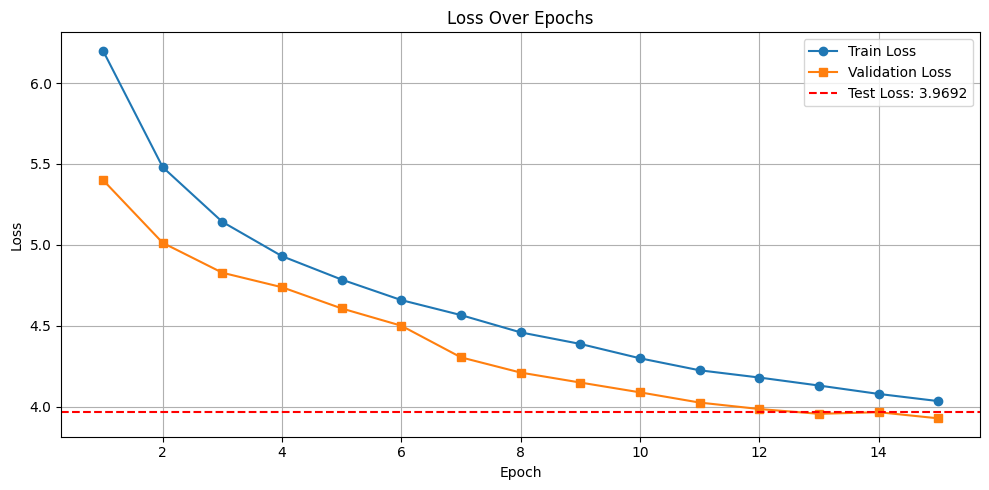

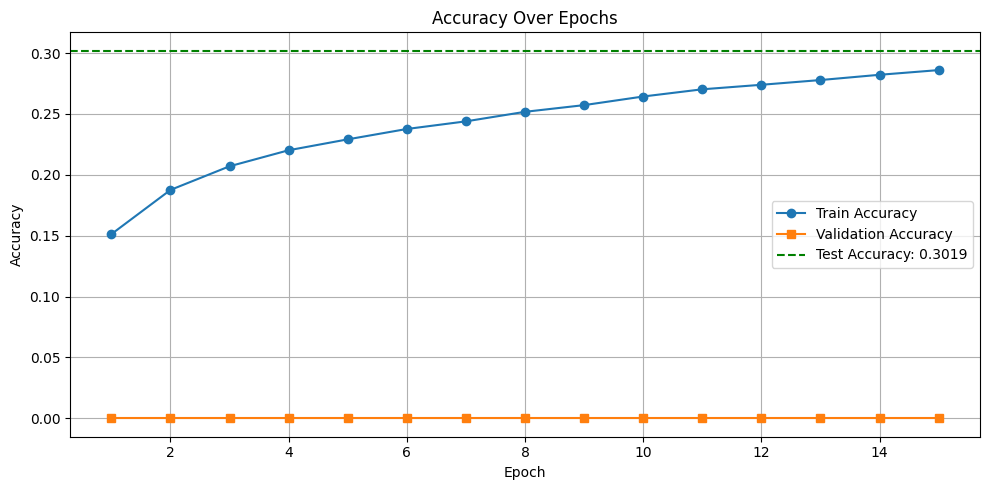

In [3]:
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer
from optimizer_scheduler import get_plateau_scheduler, linear_teacher_scheduler
from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt

# === Simple token-level dropout ===
def random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=1):
    keep_mask = (torch.rand_like(input_ids.float()) > dropout_prob).long()
    return input_ids * keep_mask + pad_token_id * (1 - keep_mask)

if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 384,
        "nhead": 6,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 1536
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
    test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "test_loss": None,
        "test_accuracy": None,
        "learning_rate": [],
        "teacher_forcing_ratio": [],
    }

    for epoch in range(15):
        model.train()
        total_loss = 0
        correct_train = total_train = 0
        tf_ratio = teacher_scheduler.step()

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/15"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            input_ids_aug = random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=pad_idx)

            optimizer.zero_grad()
            output = model(
                src=input_ids_aug,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                pred_ids = logits.argmax(dim=-1)
                correct_train += (pred_ids == targets).sum().item()
                total_train += targets.numel()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        torch.cuda.empty_cache()
        val_loss, val_metrics = validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)

        if isinstance(val_metrics, dict):
            val_accuracy = val_metrics.get("accuracy", 0.0)
        else:
            val_accuracy = val_metrics

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)

        plateau_scheduler.step(val_loss)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # === Final Test Evaluation ===
    torch.cuda.empty_cache()
    model.eval()
    correct = total = 0
    total_test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0)
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            total_test_loss += loss.item()

            pred_ids = logits.argmax(dim=-1)
            correct += (pred_ids == targets).sum().item()
            total += targets.numel()

    avg_test_loss = total_test_loss / len(test_loader)
    accuracy = correct / total
    history["test_loss"] = avg_test_loss
    history["test_accuracy"] = accuracy

    print(f"\n Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.4f}")

    with open("augmented_history.json", "w") as f:
        json.dump(history, f, indent=2)

    epochs = list(range(1, len(history["train_loss"]) + 1))

    # === Loss Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_plot_augmented.png")
    plt.show()

    # === Accuracy Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history["train_accuracy"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy", marker="s")
    plt.axhline(y=history["test_accuracy"], color='g', linestyle='--', label=f"Test Accuracy: {history['test_accuracy']:.4f}")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_plot_augmented.png")
    plt.show()
